<a href="https://colab.research.google.com/github/prbisv/NoteApplication/blob/master/Chatbot_LSTM_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.2 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
import pickle
import string
import re

import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model

import sklearn
from sklearn.model_selection import train_test_split

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
intents_file = open('/content/drive/MyDrive/Capstone Project/Colab Notebook/datasets/mentalhealth_intent_update2_new.json').read()
open_intents = json.loads(intents_file)

open_intents

{'intents': [{'tag': 'salam',
   'patterns': ['Halo',
    'Halo Booboo',
    'Hai',
    'Selamat pagi',
    'Selamat siang',
    'Selamat sore',
    'Selamat malam',
    'Apa kabar?',
    'Hai, mau tanya dong',
    'Halo, saya mau bertanya',
    'Aku mau curhat'],
   'responses': ['Halo! Namaku Booboo. Aku bersedia menjadi teman bicaramu, juga bisa membantumu untuk mengetahui informasi dasar seputar kesehatan mental. Apa yang ingin kamu tanyakan atau sampaikan?'],
   'context': ['']},
  {'tag': 'depresi',
   'patterns': ['Bagaimana cara mengubah perasaan saya tidak berharga bagi semua orang?',
    'Saya nyaris tidak tidur dan tidak melakukan apa-apa selain memikirkan bagaimana saya tidak berharga dan bagaimana saya seharusnya tidak berada di sini',
    'Saya memiliki banyak masalah',
    'Saya memiliki sejarah panjang depresi dan mulai memiliki kecemasan',
    'Saya menghadapi depresi dan kecemasan yang parah',
    'Bagaimana cara mengatasi kecemasan dan depresi ini?',
    'Saya merasa

In [6]:
#importing the dataset
with open('/content/drive/MyDrive/Capstone Project/Colab Notebook/datasets/mentalhealth_intent_update2_new.json') as content:
  data1 = json.load(content)
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})
data

,inputs,tags
0,Halo,salam
1,Halo Booboo,salam
2,Hai,salam
3,Selamat pagi,salam
4,Selamat siang,salam
...,...,...
164,Dadah!,bye_thanks
165,Selamat tinggal,bye_thanks
166,"Makasih ya, ini sangat membantu",bye_thanks
167,"Terima kasih, aku merasa lebih baik sekarang",bye_thanks


In [7]:
#removing punctuations
import string

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('indonesian'))

data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data['inputs'] = data['inputs'].apply(lambda wrd: REPLACE_BY_SPACE_RE.sub(' ', wrd))
data['inputs'] = data['inputs'].apply(lambda wrd: BAD_SYMBOLS_RE.sub(' ', wrd))
data['inputs'] = data['inputs'].apply(lambda wrd: ' '.join(word for word in wrd.split() if word not in STOPWORDS))

#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [8]:
#input length
input_shape = x_train.shape[1]
print(input_shape)
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
#output length
output_length = le.classes_.shape[0]
print("output length: ",output_length)

15
number of unique words :  307
output length:  16


In [9]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [10]:
#creating the model
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
#training the model
callbacks = myCallback()
train = model.fit(x_train,y_train,epochs=200,callbacks=callbacks)

Epoch 1/200
6/6 [==============================] - 2s 9ms/step - loss: 2.7724 - accuracy: 0.0592
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 2.7659 - accuracy: 0.1302
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 2.7598 - accuracy: 0.1302
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 2.7548 - accuracy: 0.1243
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 2.7466 - accuracy: 0.1243
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 2.7386 - accuracy: 0.1243
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 2.7316 - accuracy: 0.1243
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 2.7206 - accuracy: 0.1243
Epoch 9/200
6/6 [==============================] - 0s 8ms/step - loss: 2.7124 - accuracy: 0.1243
Epoch 10/200
6/6 [==============================] - 0s 8ms/step - loss: 2.7057 - accuracy: 0.1243
Epoch 11/200
6/6 [===========

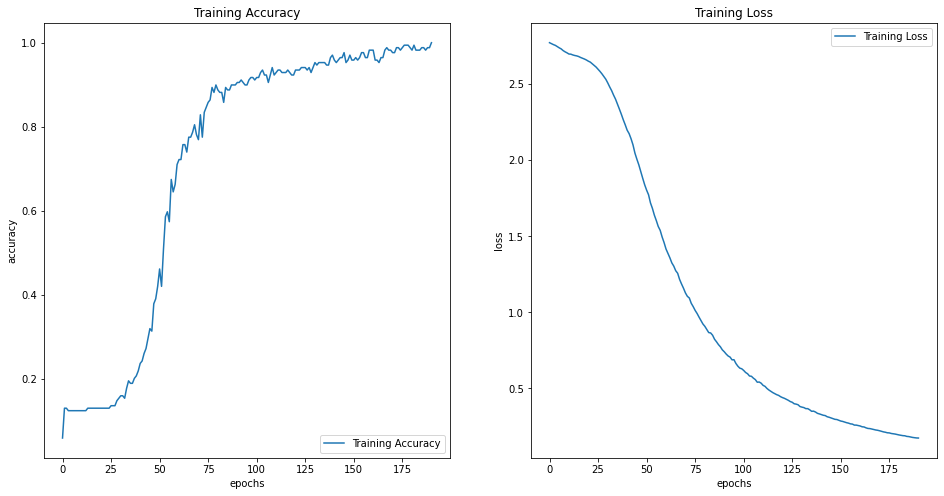

In [11]:
#learning curves 

acc = train.history['accuracy']
loss=train.history['loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [14]:
#chatting
import random
while True:
  texts_p = []
  prediction_input = input('You : ')
  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)
  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)
  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()
  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Chatbot : ",random.choice(responses[response_tag]))
  if response_tag == "bye_thanks":
    break

You : hai
1/1 [==============================] - 0s 18ms/step
Chatbot :  Halo! Namaku Booboo. Aku bersedia menjadi teman bicaramu, juga bisa membantumu untuk mengetahui informasi dasar seputar kesehatan mental. Apa yang ingin kamu tanyakan atau sampaikan?
You : Semuanya membuat saya kesal
1/1 [==============================] - 0s 23ms/step
Chatbot :  Menjaga kesehatan emosional sama pentingnya dengan menjaga kesehatan tubuh, karena keduanya saling memengaruhi. Anda dapat meenangkan diri dengan mengambil napas panjang dan menutup mata setiap kali emosi, membuat sudut pandang yang membuat anda merasa lebih baik, menghindari situasi yang membuat anda mudah merasakan emosi negatif, menjalin komunikasi dengan orang-orang di sekitar anda seperti keluarga, teman, tetangga yang membuat anda merasa nyaman. Anda dapat berbagi permasalahan anda kepada orang yang anda percayai dan nyaman, menemukan aktivitas yang membuat anda senang, rutin melakukan olahraga, mengonsumsi makanan sehat yang kaya nu

In [16]:
#save model

model.save("chatbot_model_lstm_v1.h5")
# model = tensorflow.keras.models.load_model("chatbot_model_new.h5")
# converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# open("chatbot_model_new.tflite", "wb").write(tflite_model)

# print("Model succesfully converted!")